# <span style="color:#8B4513;"> Machine Learning and RNA-Seq Data of Parkinson Disease
</span>



[<span style="color:#8B4513;">Author: **Zainab Nazari**</span>](mailto:z.nazari@ebri.com)
 
 <span style="color:#8B4513;">EBRI – European Brain Research Institute Rita Levi-Montalcini | MHPC - Master in High Performance Computing</span>
 


## Introduction
By employing machine learning in PPMI clinical data set, we can develop predictive models that aid in the early diagnosis of the disease. These models can potentially identify specific genetic markers or gene signatures that correlate with disease progression or response to treatment.

## Table of Contents
- [Matrix of Gene IDs and Counts for Pateints](#matrixcreation)
- [Data Preprocessing STEP I](#preprocessing)
- [Data Preprocessing STEP II](#preprocessing2)
- [Model Training](#training)
- [Results and Evaluation](#results)

## Matrix of Gene IDs and Counts for Pateints
- Loading the data from IR3/counts folder and extracting the associated last column (counts) of each patient file for their BL visit.


## Data Preprocessing STEP I
- We remove patients that have these diseases: SNCA (ENRLSNCA), GBA (ENRLGBA), LRRK2 (ENRLLRRK2).
-  We only keep genes with the intersection of counts and quants with proteing coding and RNAincs.
- We remove the duplicated gene IDs in which they are also lowly expressed.
- We keep only patients with diagnosis of Health control or Parkinson disease.
- We check if there are some patients were they were taking dopomine drug, so we exclude them.

## Data Preprocessing STEP II
1. Removing lowely expressed genes, by keeping only genes that had more than five counts in at least 10% of the individuals, which left us with 21,273 genes

2. DESeq2: we estimated size factors, normalized the library size bias using these factors, performed independent filtering to remove lowly expressed genes using the mean of normalized counts as a filter statistic. This left us with 12,612 genes

3. DESeq2: we applied a variance stabilizing transformation to accommodate the problem of unequal variance across the range of mean values.

4. limma: we used control samples to estimate the batch effect of the site, that we subsequently removed in both controls and cases 

5. using limma: we removed further confounding effects due to sex and RIN value.

## Model Training
Build and train machine learning models on the prepared data. Explain the choice of models, feature engineering techniques, and hyperparameter tuning. Provide code and comments to walk through the model training process.

## Results and Evaluation
Present the results of the trained models, including performance metrics, accuracy, or any relevant evaluation measures. Interpret the findings and discuss the implications. Include visualizations or tables to support the results.

## Conclusion
Summarize the key findings, limitations of the analysis, and potential future work or improvements. Offer closing remarks or suggestions for further exploration.

## References
- [**Parkinson’s Progression Markers Initiative (PPMI)**](https://www.ppmi-info.org/)

- [**A Machine Learning Approach to Parkinson’s Disease Blood Transcriptomics**](https://www.mdpi.com/2073-4425/13/5/727)

- [**Quality Control Metrics for Whole Blood Transcriptome Analysis in the Parkinson’s Progression Markers Initiative (PPMI)**](https://www.medrxiv.org/content/10.1101/2021.01.05.21249278v1)



In [2]:
# In case you do not have following packages installed, uncomment instalisation.

import pandas as pd
import numpy as np
import os
import glob
import functools
from pathlib import Path
import matplotlib.pyplot as plt

#!pip install dask[complete];
# you need to run these in case dask gives you error, it might need update.
#!pip install --upgrade pandas "dask[complete]"
#python -m pip install "dask[dataframe]" --upgrade
import dask.dataframe as dd

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.utils import class_weight

#!pip3 install xgboost
from xgboost import XGBClassifier

#!pip install conorm
import conorm # for tmm normalisation

#!pip install pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

In [3]:
# Note that the counts file in the IR3 is around 152 G, and the files are located in scratch area.

path_to_files="/scratch/znazari/PPMI_ver_sep2022/RNA_Seq_data/star_ir3/counts/"
path1=Path("/scratch/znazari/PPMI_ver_sep2022/RNA_Seq_data/star_ir3/counts/")
path2 = Path("/home/znazari/data") # where the output data will be saved at the end.
path3=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics/")

<a id="matrixcreation"></a>
## Matrix of Gene IDs and Counts for Pateints
 Loading the data from IR3/counts folder and extracting the associated last column (counts) of each patient file for their BL visit.

In [3]:
#reading the files which are in BL (Base line) visit.
specific_word = 'BL'
ending_pattern = '*.txt'
file_pattern = f'*{specific_word}*.{ending_pattern}'
file_paths = glob.glob(path_to_files + file_pattern)
# 'bl.txt' is a file that ccontains the name of the files with patient, BL, IR3, counts.
filename = 'bl.txt'
file_path_2 = os.path.join(path_to_files, filename)
bl_files = pd.read_csv(file_path_2,header=None)

# We define a function where we can take the second phrase seperated by dot. The second phrase 
# is the patient ID. So with this functin we want to get the patient IDs from their file's name
def function_names(fname):
    tokens=fname.split('.')
    return tokens[1]

# we create a list with the name of the each patients.
bl_list = [function_names(bl_files.iloc[i][0]) for i in range(len(bl_files))]

# here we read all the files with with base visit(BL) from the counts folder (where we have all the files
# for all the patients and all the visit).
list_bl_files = [dd.read_csv(path1/bl_files.iloc[i][0],skiprows=1,delimiter='\t') for i in range(len(bl_files))]


# we get th last columns of each file in the list
last_columns = [ddf.iloc[:, -1:] for ddf in list_bl_files]

# concatinating the list of the columns in a single file.
single_file = dd.concat(last_columns, axis=1)

# we change the name of the each columns with the patient numbers.
single_file.columns = bl_list

# we get the Geneid column and convert it to dask dataframe
pd_tmp_file = list_bl_files[3].compute()
geneid = pd_tmp_file['Geneid']
ddf_geneid = dd.from_pandas(geneid, npartitions=1)

# here we set the Geneid column as the index of the matrix.
ddf_new_index = single_file.set_index(ddf_geneid)

# converting to pandas data frame and saving.
ir3_counts = ddf_new_index.compute()
ir3_counts.to_csv(path2/"matrix_ir3_counts_bl.csv")

/home/znazari/anaconda3/lib/python3.9/site-packages/dask/dataframe/multi.py:1291: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


<a id="preprocessing"></a>
## Data Preprocessing STEP I

- We remove patients that have these diseases: SNCA (ENRLSNCA), GBA (ENRLGBA), LRRK2 (ENRLLRRK2).
- dopamin drug using
-  We only keep genes with the intersection of counts and quants with proteing coding and RNAincs.
- We remove the duplicated gene IDs in which they are also lowly expressed.
- We keep only patients with diagnosis of Health control or Parkinson disease.
- We check if there are some patients were they were taking dopomine drug, so we exclude them.


In [19]:
# reading the file
read_ir3_counts = pd.read_csv(path2/"matrix_ir3_counts_bl.csv")
# setting the geneid as indexing column
read_ir3_counts.set_index('Geneid', inplace=True)
# result with removing the after dot (.) value, i.e. the version of the geneIDs is removed.
read_ir3_counts.index =read_ir3_counts.index.str.split('.').str[0]


#here we delete the duplicated gene IDs, first we find them then remove them from the gene IDs
# as they are duplicated and also they are very lowly expressed either zero or one in rare caes.

# Check for duplicate index values
is_duplicate = read_ir3_counts.index.duplicated()

# Display the duplicate index values
duplicate_indices = read_ir3_counts.index[is_duplicate]

# drop them (duplicated indices and their copies are deleted, 45 duplicatd indices and 90 are dropped)
to_be_deleted = list(duplicate_indices)
read_ir3_counts = read_ir3_counts.drop(to_be_deleted)

# we read the file where we have an intersection of geneIDs in IR3, counts, quant
intersect = pd.read_csv(path2/"intersect_IR3_ENG_IDs_LincRNA_ProtCoding_counts_quant_gene_transcript_only_tot_intsersect.txt")
intersection = read_ir3_counts.index.intersection(intersect['[IR3_gene_counts] and [IR3_quant_gene] and [IR3_quant_trans] and [lncRNA+ProtCod]: '])
filtered_read_ir3_counts = read_ir3_counts.loc[intersection]

# reading the file which contains diagnosis
diago=pd.read_csv(path3/"Participant_Status.csv", header=None )
diago1=diago.rename(columns=diago.iloc[0]).drop(diago.index[0]).reset_index(drop=True)

#this is to remove patients that have these diseases: SNCA (ENRLSNCA), GBA (ENRLGBA), LRRK2 (ENRLLRRK2)
filtered_SNCA_GBA_LRRK2 = diago1[(diago1['ENRLSNCA'] == "0")& (diago1['ENRLGBA'] == "0")& (diago1['ENRLLRRK2'] == "0")]

#patients with their diagnosis
patinets_diagnosis = filtered_SNCA_GBA_LRRK2[['PATNO','COHORT_DEFINITION']].reset_index(drop=True)

# Define the particular names to keep
names_to_keep = ['Healthy Control', "Parkinson's Disease"]


# Filter the dataframe based on the specified names
PK_HC_pateints = patinets_diagnosis[patinets_diagnosis['COHORT_DEFINITION'].isin(names_to_keep)]

# Get the list of patient IDs with diagnosis from the second dataframe
patient_ids_with_diagnosis = PK_HC_pateints['PATNO']
list_patients=list(patient_ids_with_diagnosis)

# Filter the columns in the first dataframe based on patient IDs with diagnosis
rna_filtered = filtered_read_ir3_counts.filter(items=list_patients)

# We read a file that contains the Patient IDs that they were taking dopomine drugs, so they needed to be excluded.
patient_dopomine = pd.read_csv(path2/'Patient_IDs_taking_dopamine_drugs.txt',delimiter='\t',  header=None)
patient_dopomine = patient_dopomine.rename(columns={0: 'Pateint IDs'})
ids_to_remove = patient_dopomine['Pateint IDs'].tolist() # put the patient IDs to list
strings = [str(num) for num in ids_to_remove] # convert them as string

# The code is iterating over each column name in rna.columns and checking if any of the strings in the strings list 
# are present in that column name. If none of the strings are found in the column name,
# then that column name is added to the new_columns list.
new_columns = [col for col in rna_filtered.columns if not any(string in col for string in strings)] 
rna_filtered = rna_filtered[new_columns]
# there were no column name (patints that use druf in this list) to be excluded in our case.
# IN CASE THERE WERE SOME PATIENTS TO BE REMOVED, the diagnosis file below needs to be amended too.

rna_filtered.to_csv(path2/'ir3_rna.csv', index=True)

# we keep only the patients that are common in the two dataframes:
common_patient_ids = list(set(PK_HC_pateints['PATNO']).intersection(rna_filtered.columns))
patient11_filtered = PK_HC_pateints[PK_HC_pateints['PATNO'].isin(common_patient_ids)]
patient11_filtered.reset_index(drop=True)

# we save the output into data folder
patient11_filtered.to_csv(path2/'patients_HC_PK_diagnosis.csv', index=False)

<a id="preprocessin2"></a>
## Data Preprocessing STEP II

1. Removing lowely expressed genes, by keeping only genes that had more than five counts in at least 10% of the individuals, which left us with 21,273 genes

2. DESeq2: we estimated size factors, normalized the library size bias using these factors, performed independent filtering to remove lowly expressed genes using the mean of normalized counts as a filter statistic. This left us with 12,612 genes

3. DESeq2: we applied a variance stabilizing transformation to accommodate the problem of unequal variance across the range of mean values.

4. limma: we used control samples to estimate the batch effect of the site, that we subsequently removed in both controls and cases 

5. limma: we removed further confounding effects due to sex and RIN value.

<a id="training"></a>
## Model Training 

Build and train machine learning models on the prepared data. Explain the choice of models, feature engineering techniques, and hyperparameter tuning. Provide code and comments to walk through the model training process.

In [4]:
rna = pd.read_csv(path2/'ir3_rna.csv')
rna.set_index('Geneid', inplace=True)
diagnosis = pd.read_csv(path2/'patients_HC_PK_diagnosis.csv')

# transposing the matrix, so the patient IDs would be the first column
rna_ir3 = rna.T

# mapping diagnosis to zero and one.
diagnosis['COHORT_DEFINITION'] = diagnosis['COHORT_DEFINITION'].map({'Healthy Control': 0, "Parkinson's Disease": 1})

# X_train: train data of RNA,  X_test: test data of RNA 
# y_train: train diagnosis, y_test: test diagnosis
X_train, X_test, y_train, y_test = train_test_split(rna_ir3, diagnosis['COHORT_DEFINITION'], test_size=.3)

In [47]:
# to see how many Parkinson and Healthy patients we have
diagnosis['COHORT_DEFINITION'].value_counts()

COHORT_DEFINITION
1    394
0    189
Name: count, dtype: int64

In [5]:
# Initialize evaluation metric lists
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
confusion_matrices = []

# Perform the iterations
for _ in range(20):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(rna_ir3, diagnosis['COHORT_DEFINITION'], test_size=.3)
    
    # Create and fit the Random Forest model
    model_rf = RandomForestClassifier(n_estimators=100)
    model_rf.fit(X_train, y_train)
    
    # Evaluate the model and store the metrics
    accuracy_scores.append(accuracy_score(y_test, model_rf.predict(X_test)))
    precision_scores.append(precision_score(y_test, model_rf.predict(X_test)))
    recall_scores.append(recall_score(y_test, model_rf.predict(X_test)))
    f1_scores.append(f1_score(y_test, model_rf.predict(X_test)))
    roc_auc_scores.append(roc_auc_score(y_test, model_rf.predict(X_test)))
    confusion_matrices.append(confusion_matrix(y_test, model_rf.predict(X_test)))

# Calculate the average evaluation metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_roc_auc = np.mean(roc_auc_scores)
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Print the average evaluation metrics
print('Average Evaluation Metrics')
print('Accuracy:  ', avg_accuracy)
print('Precision: ', avg_precision)
print('Recall:    ', avg_recall)
print('F1:        ', avg_f1)
print('ROC-AUC:   ', avg_roc_auc)
print('\nAverage Confusion Matrix\n', avg_confusion_matrix)


Average Evaluation Metrics
Accuracy:   0.6577142857142857
Precision:  0.6802645822169885
Recall:     0.9252140777830522
F1:         0.7829465139799828
ROC-AUC:    0.5243565153049438

Average Confusion Matrix
 [[  6.95  51.05]
 [  8.85 108.15]]


<a id="results"></a>
## Results and Evaluation 

Present the results of the trained models, including performance metrics, accuracy, or any relevant evaluation measures. Interpret the findings and discuss the implications. Include visualizations or tables to support the results.

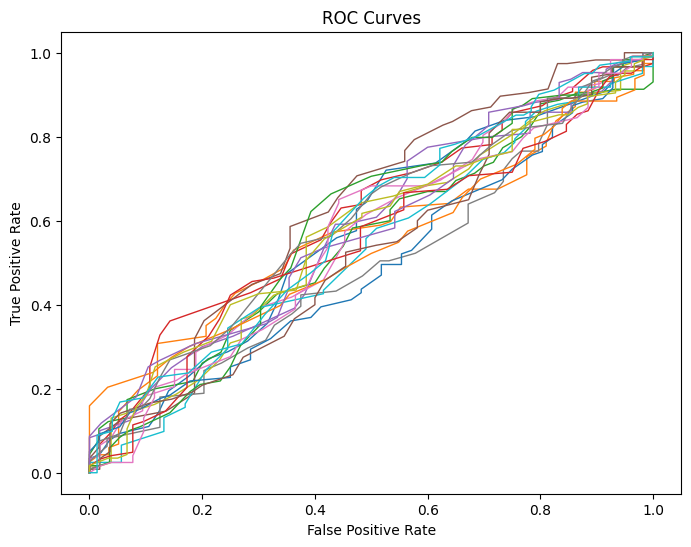

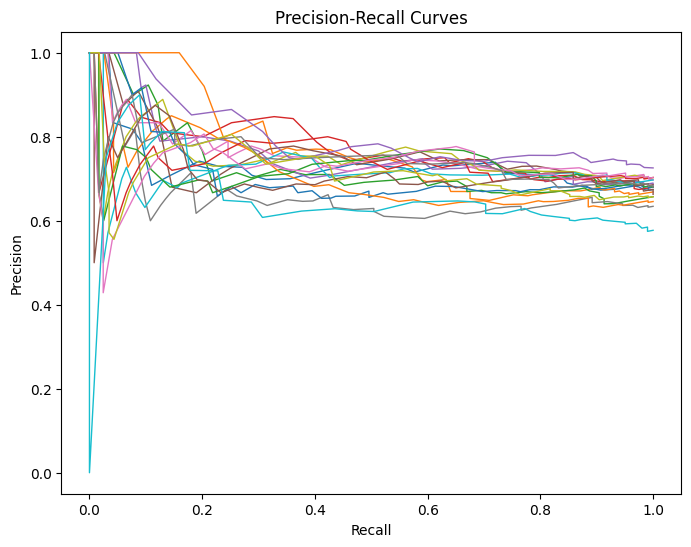

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

# Initialize lists to store the ROC and precision-recall data
roc_curves = []
precision_recall_curves = []

# Perform the iterations
for _ in range(20):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(rna_ir3, diagnosis['COHORT_DEFINITION'], test_size=.3)
    
    # Create and fit the Random Forest model
    model_rf = RandomForestClassifier(n_estimators=100)
    model_rf.fit(X_train, y_train)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
    roc_curves.append((fpr, tpr))
    
    # Calculate the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
    precision_recall_curves.append((precision, recall))

# Plot ROC curves
plt.figure(figsize=(8, 6))
for fpr, tpr in roc_curves:
    plt.plot(fpr, tpr, lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
for precision, recall in precision_recall_curves:
    plt.plot(recall, precision, lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.show()


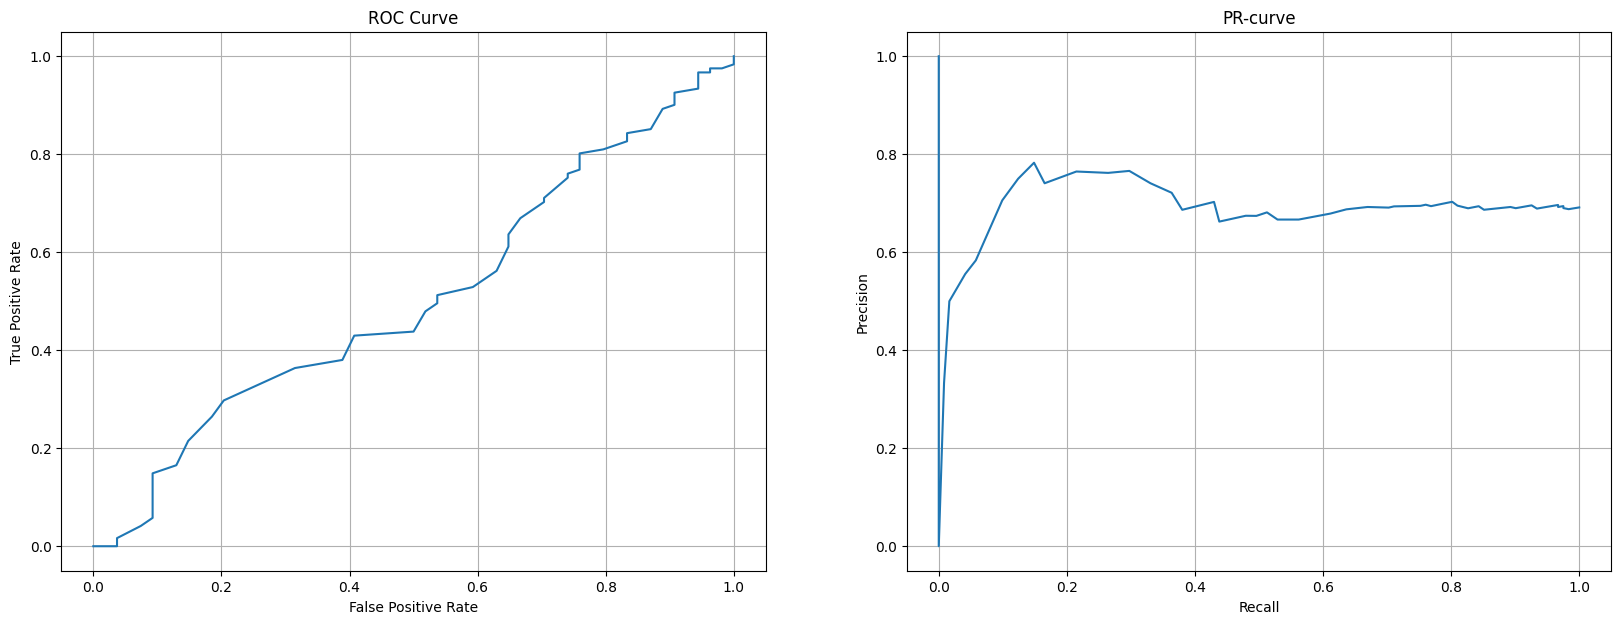

In [6]:
#ploting roc curve and precision recall curve
roc = roc_curve(y_test,model_rf.predict_proba(X_test)[:,1])
pr  = precision_recall_curve(y_test,model_rf.predict_proba(X_test)[:,1])

f = plt.figure(figsize=(20,7))
ax = f.add_subplot(121)
ax.plot(roc[0],roc[1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve')
ax.grid(which='both')
ax = f.add_subplot(122)
ax.plot(pr[1],pr[0])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('PR-curve')
ax.grid(which='both')
plt.show()